In [1]:
# ====== Packages =======
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from prettytable import PrettyTable
from tqdm import tqdm


# ---- data manipulators ----
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import resample

# ---- algorithms ----
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

# ---- evaluation ------
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, RocCurveDisplay, roc_curve, precision_recall_curve

# ---- user defined modules ----
import pre_proccessing_helpers as hel
import models_helpers as mh

# This line makes matplotlib plot the figures inside the norebook
%matplotlib inline

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10

In [2]:
dataset = pd.read_pickle('pre_proccessed_data.pkl')
dataset

,test_week,cough,fever,sore_throat,shortness_of_breath,head_ache,test_indication,corona_result
0,18,no cough,no fever,no sore_throat,no shortness_of_breath,no head_ache,Other,0
1,18,cough,no fever,no sore_throat,no shortness_of_breath,no head_ache,Other,0
2,18,no cough,fever,no sore_throat,no shortness_of_breath,no head_ache,Other,0
3,18,cough,no fever,no sore_throat,no shortness_of_breath,no head_ache,Other,0
4,18,cough,no fever,no sore_throat,no shortness_of_breath,no head_ache,Other,0
...,...,...,...,...,...,...,...,...
278842,11,no cough,no fever,no sore_throat,no shortness_of_breath,no head_ache,Other,0
278843,11,no cough,no fever,no sore_throat,no shortness_of_breath,no head_ache,Other,0
278844,11,no cough,no fever,no sore_throat,no shortness_of_breath,no head_ache,Other,0
278845,11,no cough,no fever,no sore_throat,no shortness_of_breath,no head_ache,Contact with confirmed,1


# MODEL

## The first algo we'll use is RandodmForest (because all features are categorial) so the encoding will be as follow: (label1, label2, label3,.....) -> (0,1,2, .....).
## This way we dont had more features (like in using one hot encoding) and also tree based algorithems are not sensetive to the magnitude of the labels.
## Trees are good for imbalnced datasets

### Encoding:

In [3]:
encode_dict = {
                'cough': {'cough': 1, 'no cough': 0},
                'fever': {'fever': 1, 'no fever': 0},
                'sore_throat': {'sore_throat': 1, 'no sore_throat': 0},
                'shortness_of_breath': {'shortness_of_breath': 1, 'no shortness_of_breath': 0},
                'head_ache': {'head_ache': 1, 'no head_ache': 0},
                'test_indication': {'Abroad': 2, 'Contact with confirmed': 1, 'Other': 0},
                'gender': {'male': 1, 'female': 0}
              }

data_for_tree = dataset.replace(encode_dict)
data_for_tree
data_for_tree.to_pickle('data_for_tree.pkl')
#hel.check_values_count(data_for_tree)

### Split the data to train and test (we will use cross validation instead of having a validation set because of the small number of 'positive number')
### Because the data is imbalanced we'll use stratified random sampling so each set will represeent the whole data.

In [4]:
X_train_raw, y_train_raw, X_test, y_test = mh.data_split(data_for_tree ,n_splits=1, test_size=0.2, train_size=0.8)

### Due to imblanced model we'll oversample the minority class:
* Its important to oversample after spliting to train and test so same samples won't be in each set and cause to overfitting.

In [5]:
X_train, y_train = mh.up_down_sampling(X_train_raw, y_train_raw, ratio=1, up=True)


In [6]:
y_train_raw.value_counts()

0    208006
1     11755
Name: corona_result, dtype: int64

In [7]:
## Trying SMOTE:
#from imblearn.over_sampling import SMOTE

#sm = SMOTE(1.0, random_state=27)
#X_train, y_train = sm.fit_resample(X_train_raw, y_train_raw)






In [8]:
y_train.value_counts()

0    208006
1    208006
Name: corona_result, dtype: int64

/home/nirlalum/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


+-----------+--------------------+
|   Metric  |       Score        |
+-----------+--------------------+
|  accuracy | 0.9465062521614095 |
|   recall  |        0.0         |
|  f1 score |        0.0         |
| presicion |        0.0         |
+-----------+--------------------+


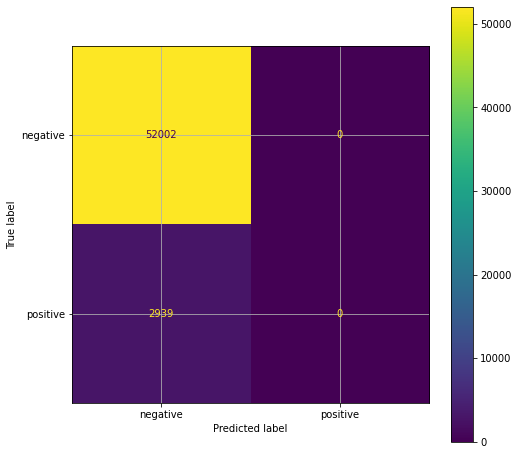

In [9]:
## Dunmmy classifier: for getting a simple baseline to compare with other classifiers
dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(X_train, y_train)
y_pred = dummy_classifier.predict(X_test)
mh.model_evaluation(y_test, y_pred)

+-----------+--------------------+
|   Metric  |       Score        |
+-----------+--------------------+
|  accuracy | 0.9232813381627564 |
|   recall  | 0.7944879210615856 |
|  f1 score | 0.5256049521665729 |
| presicion | 0.3927009754456778 |
+-----------+--------------------+


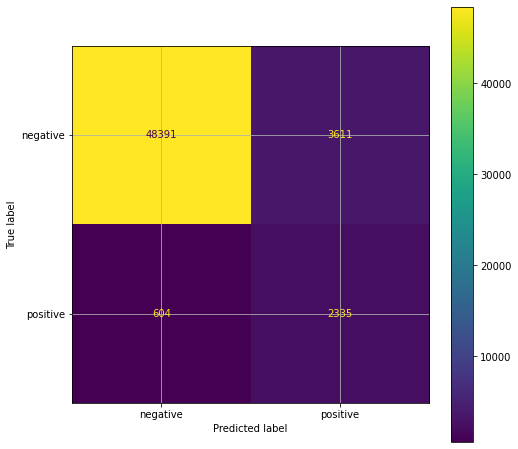

In [10]:
# train model
rfc = RandomForestClassifier(n_estimators=10, class_weight={0: 1, 1: 1})
rfc.fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

mh.model_evaluation(y_test, rfc_pred)




## Find optimal threshold using ROC curve:
### Because the data is imbalanced it tends to give high probs to samples to be from the majority class and low prob to samples to be from the minority class. So we would like to find an optimal threshold that solves this issue. we will likely get a lower threshold so samples will be tagged as the minority for lower probs. 

+-----------+---------------------+
|   Metric  |        Score        |
+-----------+---------------------+
|  accuracy |  0.9266121839791777 |
|   recall  |  0.7910854031983668 |
|  f1 score |  0.5355908776779544 |
| presicion | 0.40484067560508447 |
+-----------+---------------------+


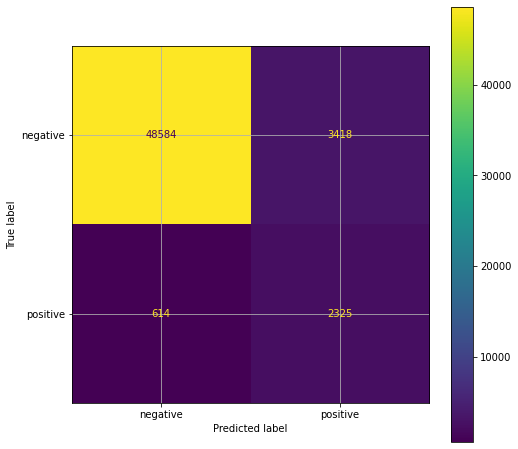

In [11]:
# train model and predict
rfc_prob = RandomForestClassifier(n_estimators=10, class_weight={0: 1, 1: 1})
rfc_prob.fit(X_train, y_train)
rfc_prob_pred = rfc_prob.predict_proba(X_test)[:,1] # take only the probs for beeing positive

# find the best threshold using ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rfc_prob_pred)
J = tpr - fpr
ix = np.argmax(J)
threshold = thresholds[ix]

# use the optimal threshold

rfc_prob_pred = 1*(rfc_prob_pred>threshold)
#rfc_prob_pred

mh.model_evaluation(y_test, rfc_prob_pred)

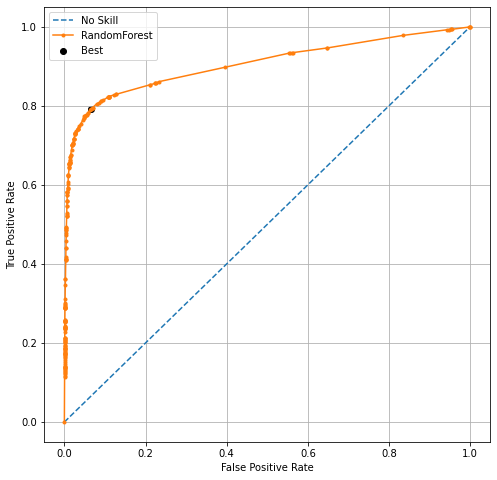

The best threshold: 0.49846153846153846


In [12]:
# plot the ROC curve
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='RandomForest')
# plot the optimal threshold
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()
print(f"The best threshold: {threshold}")

## Precision-Recall Curve:

+-----------+--------------------+
|   Metric  |       Score        |
+-----------+--------------------+
|  accuracy | 0.9698221728763583 |
|   recall  | 0.6468186457978904 |
|  f1 score | 0.6963369963369963 |
| presicion | 0.7540658468861563 |
+-----------+--------------------+


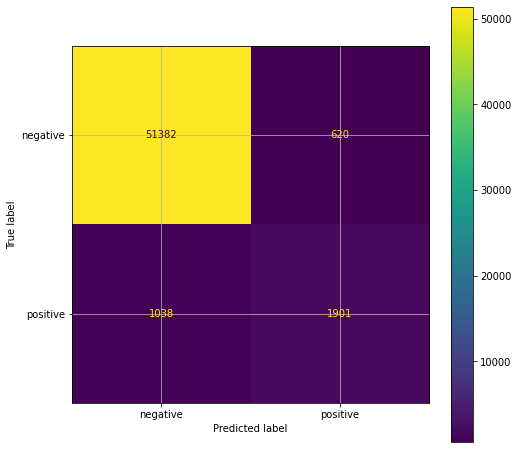

In [13]:
# train model and predict
rfc_prob = RandomForestClassifier(n_estimators=10, class_weight={0: 1, 1: 1})
rfc_prob.fit(X_train, y_train)
rfc_prob_pred = rfc_prob.predict_proba(X_test)[:,1] # take only the probs for beeing positive

# find the best threshold using ROC curve
precision, recall, thresholds = precision_recall_curve(y_test, rfc_prob_pred)
f_score = 2*(precision*recall)/(precision+recall)
ix = np.argmax(f_score)
threshold = thresholds[ix]

# use the optimal threshold

rfc_prob_pred = 1*(rfc_prob_pred>threshold)
#rfc_prob_pred

mh.model_evaluation(y_test, rfc_prob_pred)

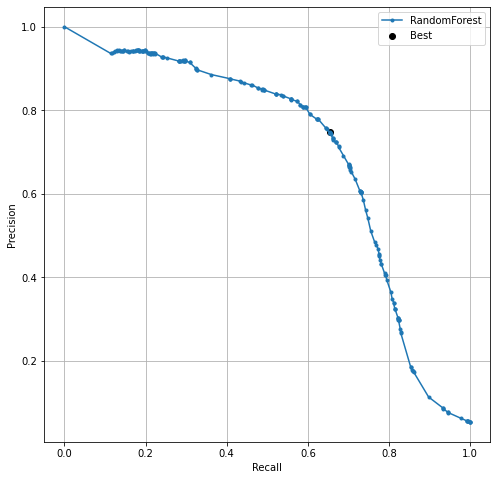

The best threshold: 0.929134025937634


In [14]:
# plot the ROC curve
plt.plot(recall, precision, marker='.', label='RandomForest')
# plot the optimal threshold
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()
print(f"The best threshold: {threshold}")

In [15]:
features_table = PrettyTable()
features_table.field_names = ['Feature name', 'Feature importance']
features = zip(rfc.feature_names_in_,rfc.feature_importances_)

for feature_name, feature_importance in features:
    features_table.add_row([feature_name, feature_importance])

print(features_table)

+---------------------+----------------------+
|     Feature name    |  Feature importance  |
+---------------------+----------------------+
|      test_week      | 0.09503414792117199  |
|        cough        | 0.12301682669631227  |
|        fever        | 0.12279483118263627  |
|     sore_throat     | 0.02448841157500325  |
| shortness_of_breath | 0.026086381230814314 |
|      head_ache      | 0.06067699707205343  |
|   test_indication   |  0.5479024043220085  |
+---------------------+----------------------+


# Note: the most important thing is to reduce the False Negative becaue we dont want people with corona on the streets -> the more important metric is recall

### Evaluation: